## 0. 데이터셋 다운로드

In [1]:
!chmod +x download.sh
!./download.sh
!unzip -q CelebA_128crop_FD.zip?dl=0 -d ./data/

--2017-12-16 11:20:02--  https://www.dropbox.com/s/e0ig4nf1v94hyj8/CelebA_128crop_FD.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/4sqb0hC1xkohlpZvZwhXzZUEy5aPZCesgzlKwcSdC552DShNqr8B5aJeVWvVqBUO/file [following]
--2017-12-16 11:20:03--  https://dl.dropboxusercontent.com/content_link/4sqb0hC1xkohlpZvZwhXzZUEy5aPZCesgzlKwcSdC552DShNqr8B5aJeVWvVqBUO/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.80.6, 2620:100:6030:6::a27d:5006
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.80.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1090119409 (1.0G) [application/zip]
Saving to: ‘./CelebA_128crop_FD.zip?dl=0’

100%[====================================>] 1,090,119,409 36.4MB/

## 1. 모듈/라이브러리 임포트

In [37]:
import torch, os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## 2. 하이퍼 파라메터

In [38]:
lr = 0.0002
max_epoch = 20
batch_size = 32
z_dim = 100
image_size = 64
g_conv_dim = 64
d_conv_dim = 64
log_step = 100
sample_step = 500
sample_num = 32
image_path = './data/CelebA/'
sample_path = './output/' 
if not os.path.exists(sample_path) : os.makedirs(sample_path)

## 3. 데이터 준비

In [39]:
transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder(image_path, transform)
data_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=8,
                          drop_last=True)

## 4. 모델 정의

In [40]:
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    """Discriminator containing 4 convolutional layers."""
    def __init__(self, image_size=128, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.fc = conv(conv_dim*8, 1, int(image_size/16), 1, 0, False)
        
    def forward(self, x):                         # If image_size is 64, output shape is as below.
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 32, 32)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 16, 16)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 8, 8)
        out = F.leaky_relu(self.conv4(out), 0.05)  # (?, 512, 4, 4)
        out = F.sigmoid(self.fc(out)).squeeze()
#         out = self.fc(out).squeeze() # Least Square
        return out.unsqueeze(1)
    
D = Discriminator(image_size)
D.cuda()

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

![iImage](dcgan.png)

In [41]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    """Generator containing 7 deconvolutional layers."""
    def __init__(self, z_dim=256, image_size=128, conv_dim=64):
        super(Generator, self).__init__()
        self.fc = deconv(z_dim, conv_dim*8, int(image_size/16), 1, 0, bn=False)
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, bn=False)
        
    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)      # If image_size is 64, output shape is as below.
        out = self.fc(z)                            # (?, 512, 4, 4)
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 256, 8, 8)
        out = F.leaky_relu(self.deconv2(out), 0.05)  # (?, 128, 16, 16)
        out = F.leaky_relu(self.deconv3(out), 0.05)  # (?, 64, 32, 32)
        out = F.tanh(self.deconv4(out))             # (?, 3, 64, 64)
        return out
    
G = Generator(z_dim,image_size,g_conv_dim)
G.cuda()

Generator(
  (fc): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv4): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

## 5. Loss/Optimizer

In [42]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss().cuda()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))

## 6. 기타 함수

In [43]:
# denormalization : [-1,1] -> [0,1]
# normalization : [0,1] -> [-1,1]
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

## 7. 트레이닝

In [45]:
# model restore if any
try:
    G.load_state_dict(torch.load('./generator.pkl'))
    D.load_state_dict(torch.load('./discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



In [ ]:
# Start training
total_batch = len(data_loader.dataset)//batch_size
fixed_z = torch.randn(sample_num, z_dim).cuda()
for epoch in range(max_epoch):
    for i, (images, _) in enumerate(data_loader):
        # Build mini-batch dataset
        images = images.cuda()
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size,1).cuda()
        fake_labels = torch.zeros(batch_size,1).cuda()

        #============= Train the discriminator =============#
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels) # BCE
#         d_loss_real = torch.mean((outputs - 1) ** 2) # Least Square
        
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, z_dim).cuda()
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels) # BCE
#         d_loss_fake = torch.mean(outputs ** 2) # Least Square
        fake_score = outputs

        # Backprop + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        #=============== Train the generator ===============#
        # Compute loss with fake images
        z = torch.randn(batch_size, z_dim).cuda()
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels) # BCE
#        g_loss = torch.mean((outputs - 1) ** 2) # Least Square

        # Backprop + Optimize
        D.zero_grad()
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % log_step == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f'
                  %(epoch, max_epoch, i+1, total_batch, d_loss.item(), g_loss.item(),
                    real_score.data.mean(), fake_score.data.mean()))
            
        if (i+1) % sample_step == 0:
            fake_images = G(fixed_z)
            torchvision.utils.save_image(denorm(fake_images.data), 
                                         os.path.join(sample_path,'fake_samples-%d-%d.png' %(epoch+1, i+1)),
                                         nrow=8)

# Save the trained parameters
torch.save(G.state_dict(), './generator.pkl')
torch.save(D.state_dict(), './discriminator.pkl')

## 8. 학습된 Generator 테스트

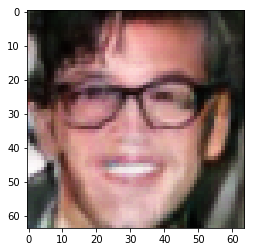

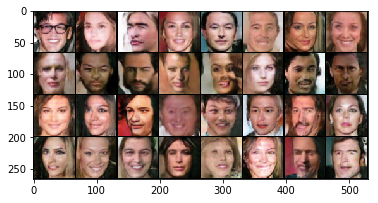

In [49]:
fixed_z = torch.randn(sample_num, z_dim).cuda()
fake_images = G(fixed_z)
plt.imshow(denorm(fake_images[0].cpu().permute(1,2,0).data).numpy())
plt.show()

plt.imshow(make_grid(denorm(fake_images).data.cpu()).permute(1,2,0).numpy())
plt.show()